# 🚲 서울시 따릉이 대여 수요 예측 - EDA
본 노트북에서는 따릉이 수요 데이터를 기반으로 다음 분석을 수행한다.

## 📌 주요 분석 항목
1. 시간대별 수요 패턴 분석
2. 요일/주말/월별 특징
3. 날씨 변수 vs 수요 상관 분석
4. POI 영향 분석
5. 이상치 탐지 및 제거

---


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

df = pd.read_csv("../../Data/interim/seoul/seoul_rental_data.csv", parse_dates=["date"])
df.head()


,date,quarter_flag,month,weekend,rental_count,used_time(avg),used_dis(avg),Holding quantity,n_station_dis(m),n_bus_dis(m),...,N_of_school_within_2000m,N_of_park_within_2000m,temperature,Precipitation,windspeed,humidity,sunshine,snowcover,cloudcover,weathersit
0,2021-01-01,0.0,1.0,0,5,7.20,423.58,15,100.21,84.31,...,16,1,-9.07,0.0,1.52,69.33,0.50,0.0,0.00,1
1,2021-01-01,2.0,1.0,0,5,26.60,1017.66,15,100.21,84.31,...,16,1,0.07,0.0,2.48,55.33,0.65,0.0,4.00,1
2,2021-01-01,3.0,1.0,0,17,25.53,1186.57,15,100.21,84.31,...,16,1,-1.75,0.0,2.28,65.83,0.42,0.0,4.67,1
3,2021-01-02,0.0,1.0,1,6,32.67,2007.42,15,100.21,84.31,...,16,1,-5.20,0.0,2.03,44.33,0.50,0.0,0.00,1
4,2021-01-02,1.0,1.0,1,1,54.00,7208.90,15,100.21,84.31,...,16,1,-6.87,0.0,2.17,36.67,0.65,0.0,0.00,1


## 기본 전처리
요일생성

In [10]:
# Create weekday number (0=Mon, ..., 6=Sun)
df["weekday"] = df["date"].dt.weekday

# Create weekday name
df["weekday_name"] = df["weekday"].map({
    0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu",
    4:"Fri", 5:"Sat", 6:"Sun"
})


## 기본 정보 출력

In [12]:
df.info()
df.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14581612 entries, 0 to 14581611
Data columns (total 42 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   date                        datetime64[ns]
 1   quarter_flag                float64       
 2   month                       float64       
 3   weekend                     int64         
 4   rental_count                int64         
 5   used_time(avg)              float64       
 6   used_dis(avg)               float64       
 7   Holding quantity            int64         
 8   n_station_dis(m)            float64       
 9   n_bus_dis(m)                float64       
 10  n_school_dis(m)             float64       
 11  n_park_dis(m)               float64       
 12  N_of_stations_within_100m   int64         
 13  N_of_bus_within_100m        int64         
 14  N_of_school_within_100m     int64         
 15  N_of_park_within_100m       int64         
 16  N_of_stations_wi

,count,mean,min,25%,50%,75%,max,std
date,14581612,2023-05-08 05:11:11.950399744,2021-01-01 00:00:00,2022-04-17 00:00:00,2023-05-23 00:00:00,2024-06-11 00:00:00,2025-06-30 00:00:00,NaN
quarter_flag,14581612.0,1.544413,0.0,0.0,2.0,3.0,3.0,1.133985
month,14581612.0,6.28918,1.0,3.0,6.0,9.0,12.0,3.372073
weekend,14581612.0,0.275675,0.0,0.0,0.0,1.0,1.0,0.446854
rental_count,14581612.0,11.951856,1.0,3.0,7.0,15.0,932.0,15.848468
used_time(avg),14581612.0,20.732544,-13.0,11.23,17.74,26.0,25284.04,21.486694
used_dis(avg),14581476.0,2373.565973,0.0,1329.74,1943.5,2894.62,160643.0,1758.170744
Holding quantity,14581612.0,12.431935,2.0,10.0,10.0,15.0,62.0,5.583883
n_station_dis(m),14581612.0,586.206141,8.36,245.79,506.5,799.34,3892.86,457.816558
n_bus_dis(m),14581612.0,93.106135,0.85,41.59,71.36,119.87,675.35,77.506227


## 시간 대별 수요 패턴 (Quarter_Flag)

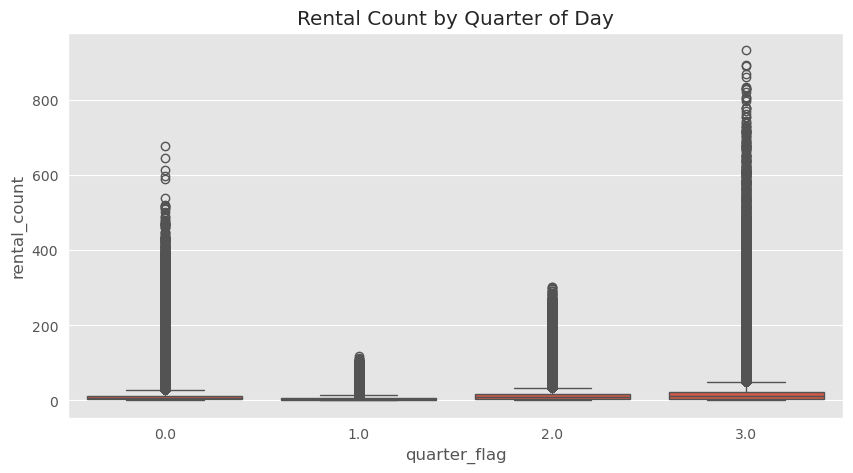

quarter_flag
0.0    10.412331
1.0     5.242505
2.0    12.520889
3.0    18.349937
Name: rental_count, dtype: float64

In [13]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="quarter_flag", y="rental_count")
plt.title("Rental Count by Quarter of Day")
plt.show()

df.groupby("quarter_flag")["rental_count"].mean()


## 요일, 주말 ,월별 패턴

### 1. 요일별 패턴

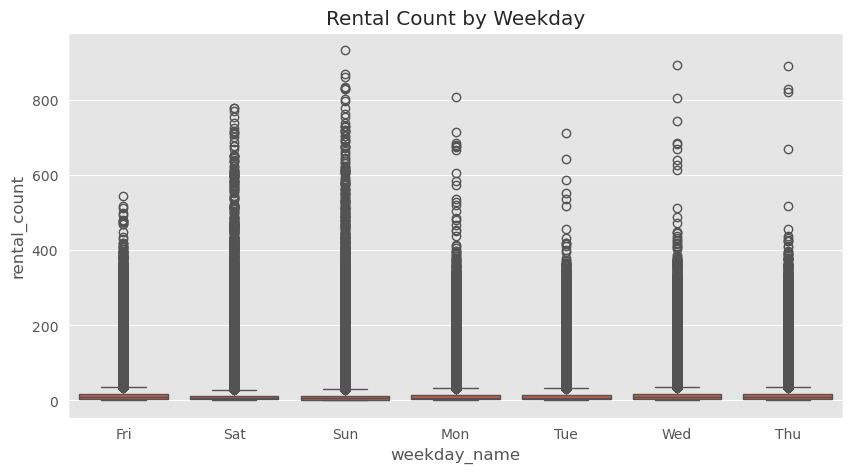

In [14]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="weekday_name", y="rental_count")
plt.title("Rental Count by Weekday")
plt.show()


### 2. 주말 vs 평일 패턴

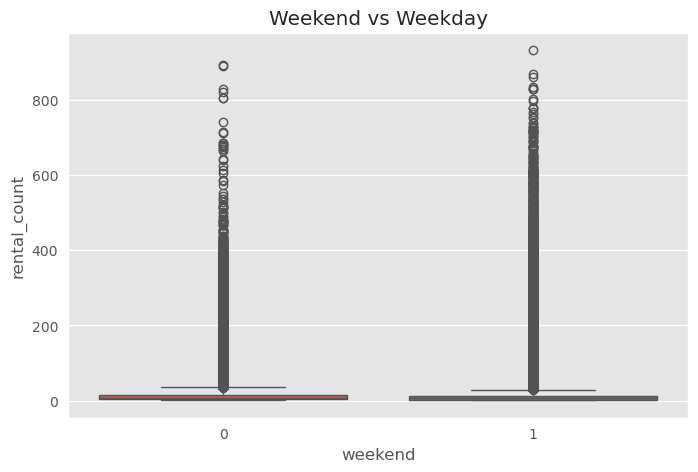

weekend
0    12.462893
1    10.609130
Name: rental_count, dtype: float64

In [15]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="weekend", y="rental_count")
plt.title("Weekend vs Weekday")
plt.show()

df.groupby("weekend")["rental_count"].mean()


### 3. 월별 패턴

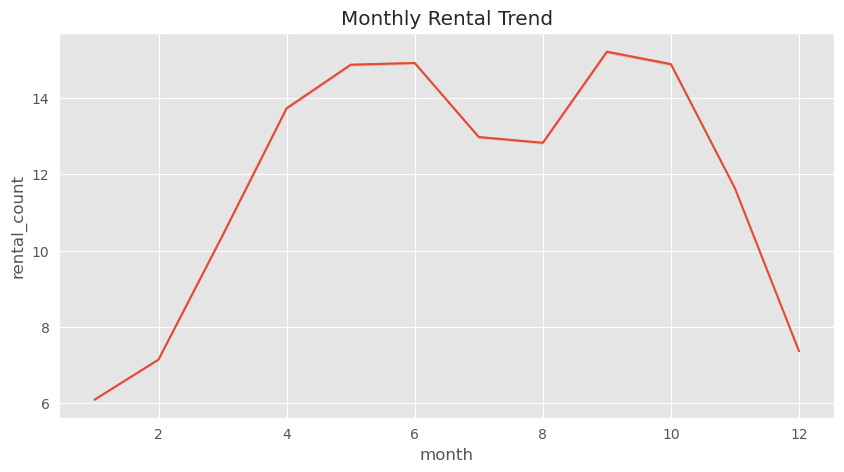

In [16]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df, x="month", y="rental_count")
plt.title("Monthly Rental Trend")
plt.show()


## 날씨 변수 VS 수요 상관 분석

temperature, Precipitation, windspeed, humidity,
sunshine, snowcover, cloudcover, weathersit

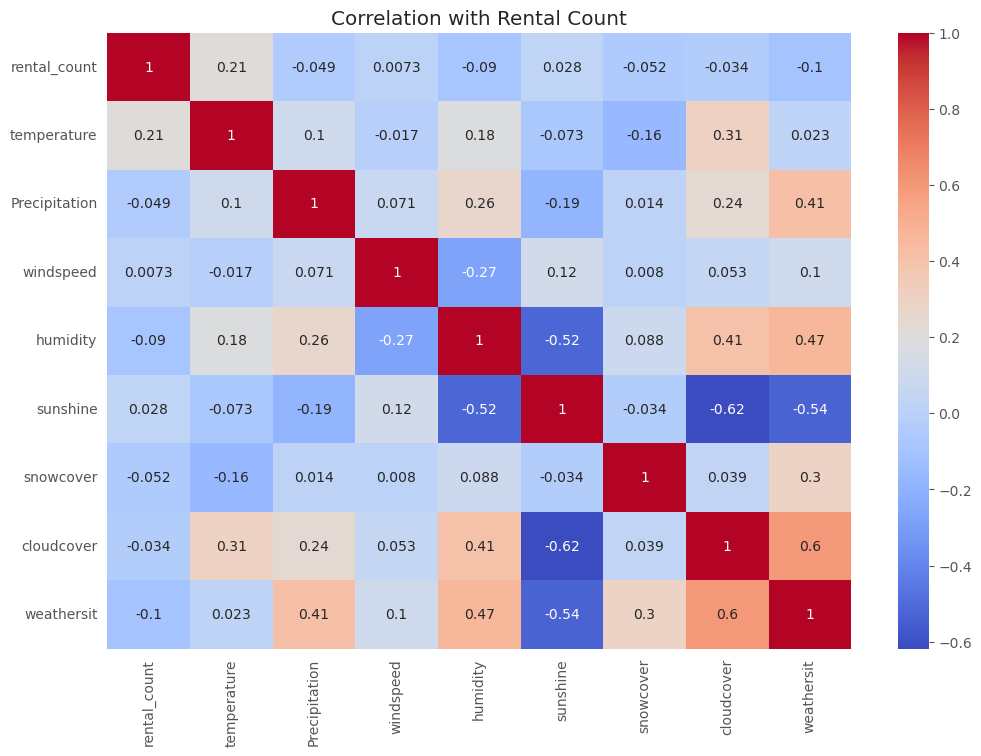

In [17]:
weather_cols = [
    "temperature", "Precipitation", "windspeed", "humidity",
    "sunshine", "snowcover", "cloudcover", "weathersit"
]

plt.figure(figsize=(12,8))
sns.heatmap(df[["rental_count"] + weather_cols].corr(),
            annot=True, cmap="coolwarm")
plt.title("Correlation with Rental Count")
plt.show()


## POI 영향 분석 (거리 + 개수)

### 1. 거리 VS 수요 산점도

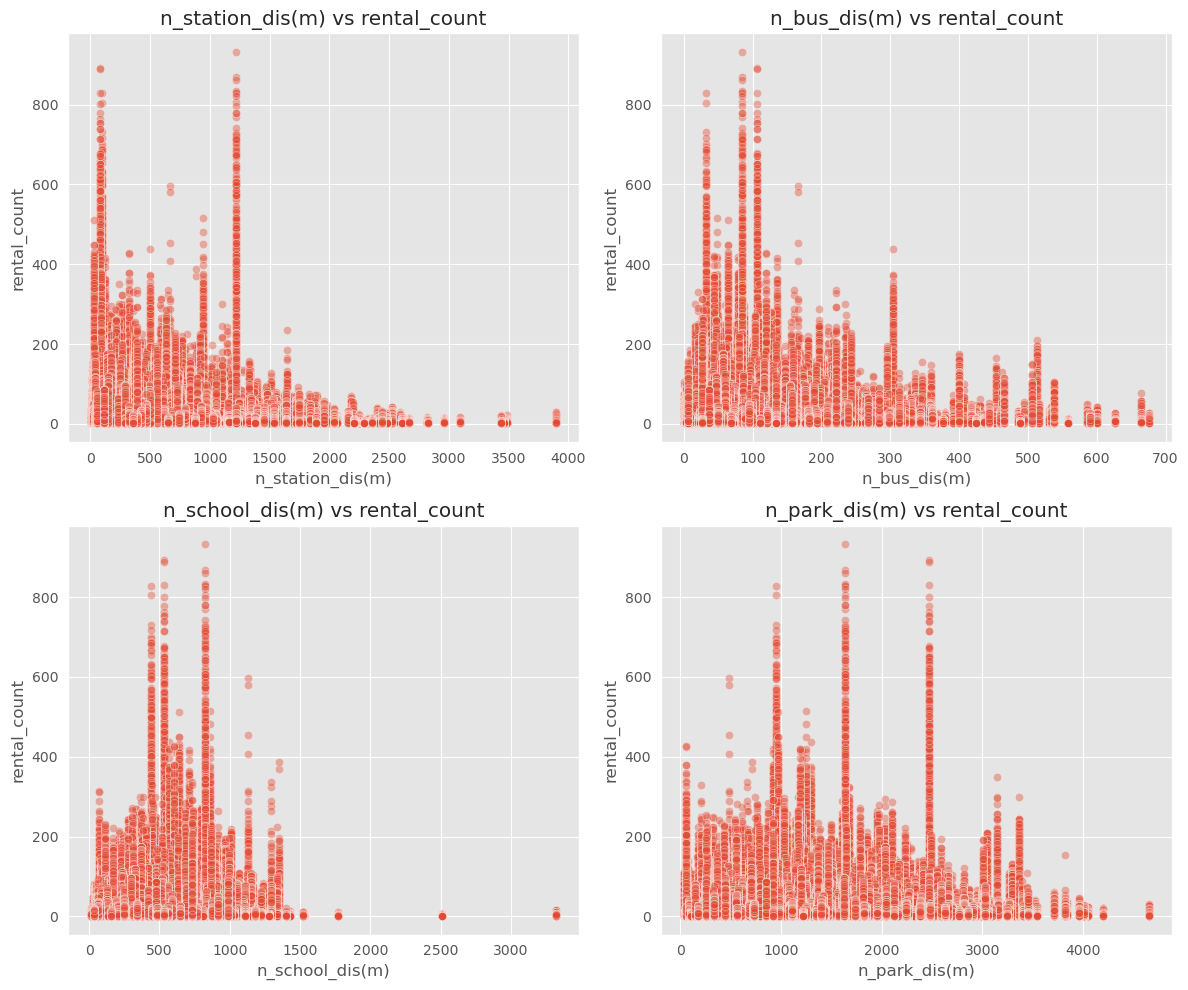

In [19]:
poi_distance_cols = [
    "n_station_dis(m)",
    "n_bus_dis(m)",
    "n_school_dis(m)",
    "n_park_dis(m)"
]
fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.flatten()

for i, col in enumerate(poi_distance_cols):
    sns.scatterplot(data=df, x=col, y="rental_count", alpha=0.4, ax=axes[i])
    axes[i].set_title(f"{col} vs rental_count")

plt.tight_layout()
plt.show()


### 2. POI 개수 변수

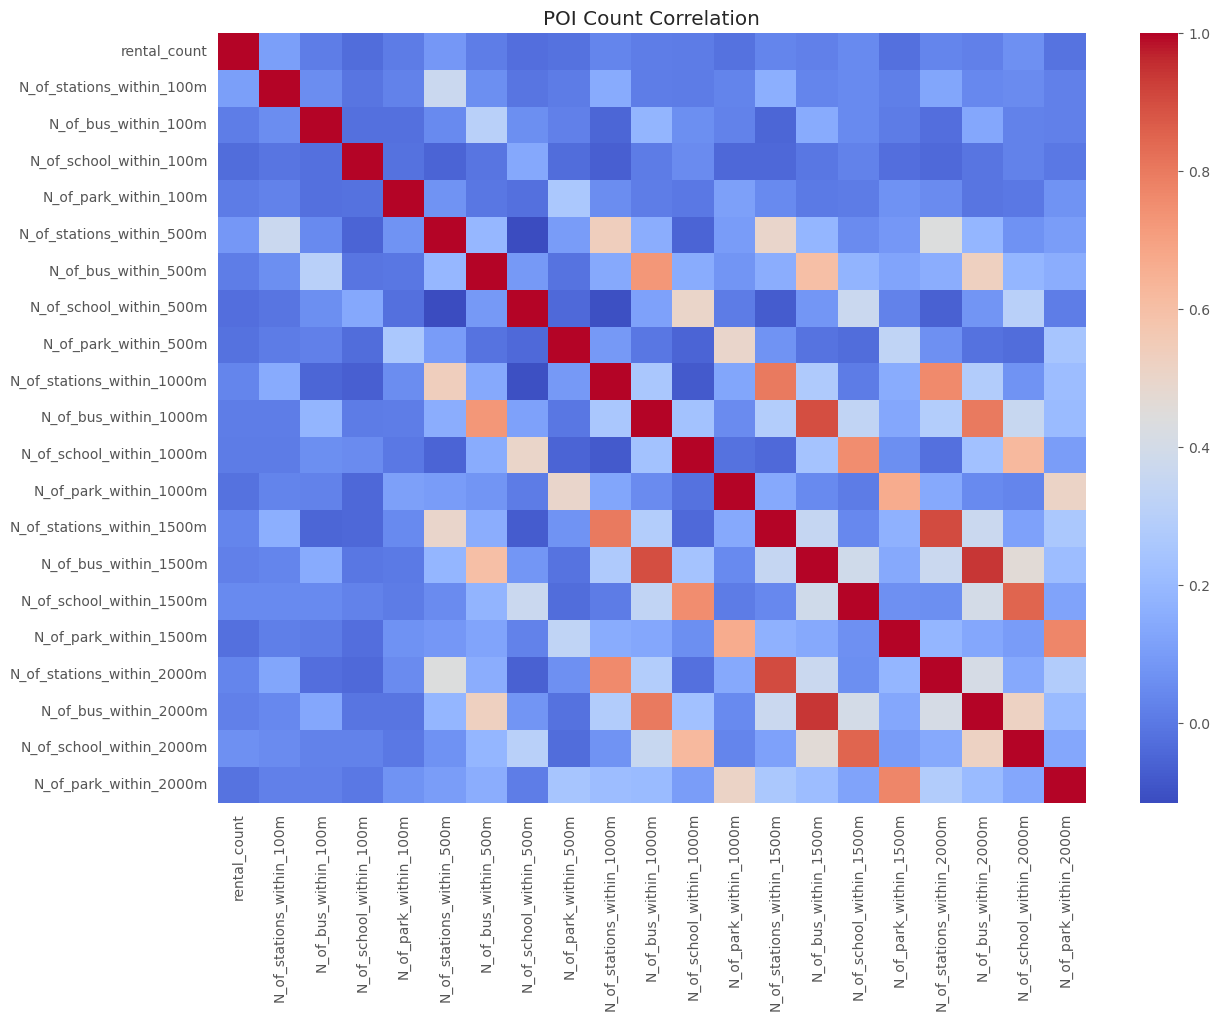

In [20]:
poi_count_cols = [c for c in df.columns if "N_of_" in c]

plt.figure(figsize=(14,10))
sns.heatmap(df[["rental_count"] + poi_count_cols].corr(),
            cmap="coolwarm")
plt.title("POI Count Correlation")
plt.show()


## IQR 방식의 이상치 탐지 및 제거

In [25]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantquantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

df_clean = remove_outliers(df, "rental_count")


### 이상치 제거 전후 비교

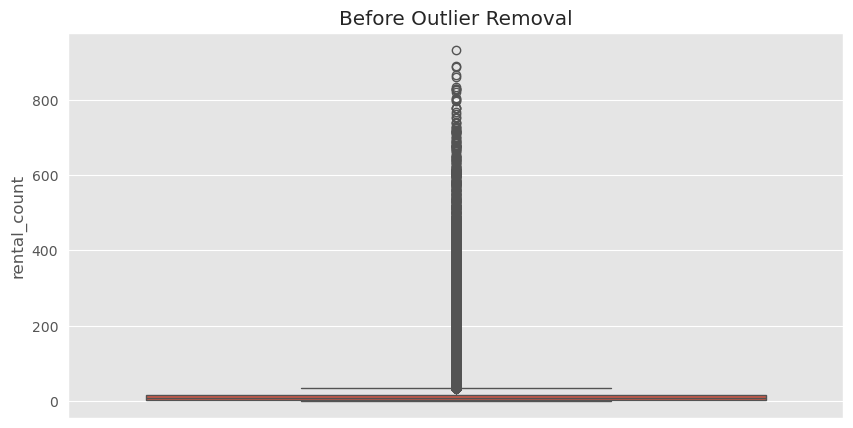

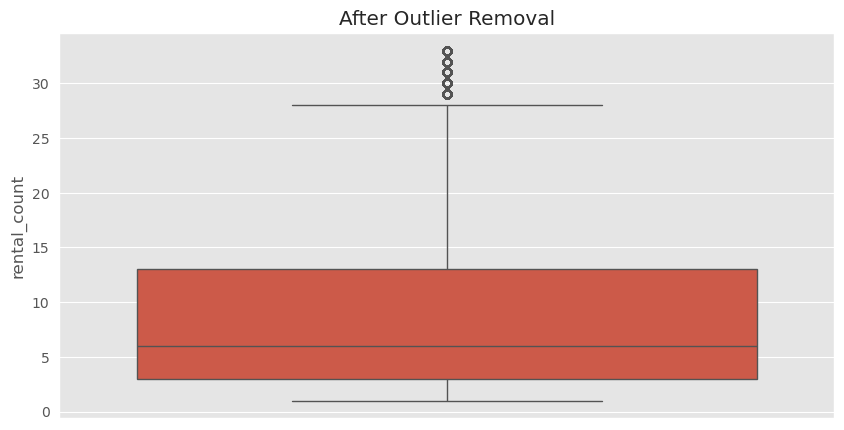

In [26]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, y="rental_count")
plt.title("Before Outlier Removal")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=df_clean, y="rental_count")
plt.title("After Outlier Removal")
plt.show()


## 분석 요약

In [28]:
summary = {
    "rows_raw": len(df),
    "rows_cleaned": len(df_clean),
    "missing_values": df.isna().sum().sum(),
    "columns": list(df.columns)
}
summary


{'rows_raw': 14581612,
 'rows_cleaned': 13565398,
 'missing_values': 136,
 'columns': ['date',
  'quarter_flag',
  'month',
  'weekend',
  'rental_count',
  'used_time(avg)',
  'used_dis(avg)',
  'Holding quantity',
  'n_station_dis(m)',
  'n_bus_dis(m)',
  'n_school_dis(m)',
  'n_park_dis(m)',
  'N_of_stations_within_100m',
  'N_of_bus_within_100m',
  'N_of_school_within_100m',
  'N_of_park_within_100m',
  'N_of_stations_within_500m',
  'N_of_bus_within_500m',
  'N_of_school_within_500m',
  'N_of_park_within_500m',
  'N_of_stations_within_1000m',
  'N_of_bus_within_1000m',
  'N_of_school_within_1000m',
  'N_of_park_within_1000m',
  'N_of_stations_within_1500m',
  'N_of_bus_within_1500m',
  'N_of_school_within_1500m',
  'N_of_park_within_1500m',
  'N_of_stations_within_2000m',
  'N_of_bus_within_2000m',
  'N_of_school_within_2000m',
  'N_of_park_within_2000m',
  'temperature',
  'Precipitation',
  'windspeed',
  'humidity',
  'sunshine',
  'snowcover',
  'cloudcover',
  'weathersit',
 